In [3]:
from random import Random

from dotenv import load_dotenv
from sqlalchemy.sql.functions import random

load_dotenv()

True

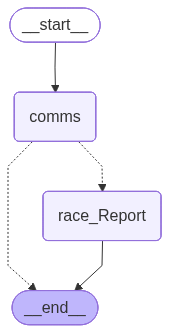

In [14]:
from typing import Literal
from IPython.display import Image, display

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.runnables import RunnableConfig

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

# LLM
model = ChatOpenAI(model="gpt-5-nano-2025-08-07", temperature=0)

# State
class SessionSummary(MessagesState):
    race_summary: str

def race_Summary(state: SessionSummary, config: RunnableConfig):
    summary = state.get("race_summary", "") # Fixed typo from Session_Summary

    base_prompt = "You are a F1 Race Engineer."
    if summary:
        system_message = f"{base_prompt} This is the race summary so far: {summary}"
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = [SystemMessage(content=base_prompt)] + state["messages"]

    response = model.invoke(messages, config)
    return {"messages": [response]}

def race_Report(state: SessionSummary):
    summary = state.get("race_summary", "")
    if summary:
        summary_message = (
            f"This is the race report so far: {summary}\n\n"
            "Update the report based on the new radio messages above:"
        )
    else:
        summary_message = "Generate a brief race report based on the radio messages above:"

    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)

    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-1]]

    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]

    # Let's refine the notebook's delete logic. It probably wants to delete all *previous* messages.
    all_message_ids = [m.id for m in state["messages"]]
    delete_messages = [RemoveMessage(id=mid) for mid in all_message_ids]

    return {
        "race_summary": response.content,
        "messages": delete_messages + [HumanMessage(content="[Summary generated, messages cleared]")] # Add a placeholder
    }


def should_generate_report(state: SessionSummary) -> Literal["race_Report", END]:
    messages = state["messages"]
    # Filter out any placeholder messages we added
    real_messages = [m for m in messages if isinstance(m, (HumanMessage, SystemMessage)) and "Summary generated" not in m.content]
    if len(real_messages) > 4:
        return "race_Report"
    return END

workflow = StateGraph(SessionSummary)
workflow.add_node("comms", race_Summary)
workflow.add_node("race_Report", race_Report) # Corrected node add

workflow.add_edge(START, "comms")
workflow.add_conditional_edges("comms", should_generate_report)
workflow.add_edge("race_Report", END)

memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

a=graph.stream({"messages": [HumanMessage(content="Box and Pit Confirm",name="Driver_LN4")]}, config, stream_mode="updates")

# Start conversation
for chunk in a:
    print(chunk['comms']['messages'])

[AIMessage(content='Copy. Here’s a clean engineer-to-driver radio you can use:\n\nLN4, box this lap. Box, box. End of this lap, pit entry on the left. Slow to pit speed and enter the box cleanly. We’ll fit [tire compound] and top up as needed. Confirm you copy.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 2506, 'prompt_tokens': 27, 'total_tokens': 2533, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 2432, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CU8HXBR1jIWYBcfh0YIHM5sVUm10d', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--dc30ed5d-8faa-4077-b332-9269c529b2e7-0', usage_metadata={'input_tokens': 27, 'output_tokens': 2506, 'total_tokens': 2533, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_

In [7]:
# Start conversation, again
config = {"configurable": {"thread_id": "2"}}

# Start conversation
input_message = HumanMessage(content="What is the status on the tyres", name="driver_LN4")
graph.stream({"messages": [input_message]}, config, stream_mode="values")

input_message = HumanMessage(content="What is the Gap to Verstappen", name="driver_LN4")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event["messages"]:
        m.pretty_print()
    print("-**-"*20)

================================ Human Message =================================
Name: driver_LN4

What is the Gap to Verstappen
================================== Ai Message ==================================

I can give you the gap, but I need a bit more context.

Please tell me:
- Which session are you asking about? (Practice, Qualifying, or the Race)
- Which track/round are we talking about?
- Do you want the current live gap or the gap on a specific lap/sector?

If you can share the latest timing data (Verstappen’s time and LN4’s time for the same lap or the current gaps shown on the timing screen), I’ll compute:
- Gap to Verstappen in seconds
- Any Delta to Verstappen’s best/lapost
- Sector-by-sector splits if available

If you don’t have the data handy, I can outline how to read it from the timing screen and compute it:
- For a live lap: Gap to Verstappen = LN4 lap time minus Verstappen’s lap time on the same lap
- For the race lead: Gap to leader is the current race time differ

In [8]:
node_to_stream = 'comms'
config = {"configurable": {"thread_id": "4"}}
input_message = HumanMessage(content="Tell me about Red Bull Sister team in 50-70 words", name="Reporter")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        print(event["data"]['chunk'].content,end="|")

|Red| Bull|’s| sister| squad| is| Sc|ud|eria| Alpha|T|auri|,| formerly| Toro| Ros|so|.| Based| in| Fa|enza|,| Italy|,| it| acts| as| Red| Bull| Racing|’s| development| team|,| nurturing| young| talent| and| testing| new| parts| on| a| lower|-budget| slate|.| Re|br|anded| in| |202|0| to| emphasize| the| Alpha|T|auri| brand|,| the| outfit| secured| a| breakthrough| win| with| Gas|ly| at| Mon|za| in| |202|0| and| continues| to| contribute| to| Red| Bull|’s| talent| pipeline|.|||

In [9]:
from langgraph_sdk import get_client

# This is the URL of the local development server
URL = "http://127.0.0.1:2024"
client = get_client(url=URL)

# Search all hosted graphs
assistants = await client.assistants.search()

In [10]:
# Create a new thread
thread = await client.threads.create()
# Input message
input_message = HumanMessage(content="Search for Norris Piastri Repercussions")
async for event in client.runs.stream(thread["thread_id"],
                                      assistant_id="agent",
                                      input={"messages": [input_message]},
                                      stream_mode="values"):
    print(event)

StreamPart(event='metadata', data={'run_id': '019a1587-3e64-761d-95dd-c89612efc93d', 'attempt': 1})
StreamPart(event='values', data={'messages': [{'content': 'Search for Norris Piastri Repercussions', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '85bd1b31-0ab9-4362-9d04-f7500c584f26', 'example': False}]})
StreamPart(event='values', data={'messages': [{'content': 'Search for Norris Piastri Repercussions', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '85bd1b31-0ab9-4362-9d04-f7500c584f26', 'example': False}, {'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_cmKJpzP7B5vTS2bpGxFKuquE', 'function': {'arguments': '{"search":"Norris Piastri repercussions"}', 'name': 'web_search'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 348, 'prompt_tokens': 251, 'total_tokens': 599, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_

In [11]:
thread = await client.threads.create()
input_message = HumanMessage(content="Add 85 to 32")
async for event in client.runs.stream(thread["thread_id"],
                                      assistant_id="agent",
                                      input={"messages": [input_message]},
                                      stream_mode="messages"):
    print(event.event)

metadata
messages/metadata
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/metadata
messages/complete
messages/metadata
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial


In [13]:
thread = await client.threads.create()
input_message = HumanMessage(content="What is your opinion on the Norris Piastri Repercussions, (Search if needed) in short",name="Reporter")

def format_tool_calls(tool_calls):
    """
    Format a list of tool calls into a readable string.

    Args:
        tool_calls (list): A list of dictionaries, each representing a tool call.
            Each dictionary should have 'id', 'name', and 'args' keys.

    Returns:
        str: A formatted string of tool calls, or "No tool calls" if the list is empty.

    """

    if tool_calls:
        formatted_calls = []
        for call in tool_calls:
            formatted_calls.append(
                f"Tool Call ID: {call['id']}, Function: {call['name']}, Arguments: {call['args']}"
            )
        return "\n".join(formatted_calls)
    return "No tool calls"

async for event in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input={"messages": [input_message]},
    stream_mode="messages",):

    # Handle metadata events
    if event.event == "metadata":
        print(f"Metadata: Run ID - {event.data['run_id']}")
        print("-" * 50)

    # Handle partial message events
    elif event.event == "messages/partial":
        for data_item in event.data:
            # Process user messages
            if "role" in data_item and data_item["role"] == "user":
                print(f"Human: {data_item['content']}")
            else:
                # Extract relevant data from the event
                tool_calls = data_item.get("tool_calls", [])
                invalid_tool_calls = data_item.get("invalid_tool_calls", [])
                content = data_item.get("content", "")
                response_metadata = data_item.get("response_metadata", {})

                if content:
                    print(f"AI: {content}")

                if tool_calls:
                    print("Tool Calls:")
                    print(format_tool_calls(tool_calls))

                if invalid_tool_calls:
                    print("Invalid Tool Calls:")
                    print(format_tool_calls(invalid_tool_calls))

                if response_metadata:
                    finish_reason = response_metadata.get("finish_reason", "N/A")
                    print(f"Response Metadata: Finish Reason - {finish_reason}")

        print("-" * 50)

Metadata: Run ID - 019a158d-4514-7047-a0bc-12abfe096536
--------------------------------------------------
Tool Calls:
Tool Call ID: call_08NwQh2xPctuySwygzoCd7zD, Function: web_search, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_08NwQh2xPctuySwygzoCd7zD, Function: web_search, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_08NwQh2xPctuySwygzoCd7zD, Function: web_search, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_08NwQh2xPctuySwygzoCd7zD, Function: web_search, Arguments: {'search': ''}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_08NwQh2xPctuySwygzoCd7zD, Function: web_search, Arguments: {'search': 'N'}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_08NwQh2xPctuySwygzoCd7zD, Function: web_search, Arguments: {'search': 'Norris'}
-------------------------------------